## Code to analyze FS output

1. DKT CT distributions 
2. ASEG vol distribution


In [2]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nibabel as nib


In [39]:
ds_name = "ylopd"

data_dir = f"/home/md_lab/projects/ylopd/data/{ds_name}/"  
session = "ses-01"
tabular_dir = f"{data_dir}/tabular/"

# manifest
manifest_csv = f"{tabular_dir}/manifest.csv"
doughnut_csv = f"{data_dir}/scratch/raw_dicom/doughnut.csv"

# demographics
demographics_csv = f"{tabular_dir}/demographics/demographics.csv"

# id_mapping
id_mapping_csv = f"{data_dir}/scratch/participant_id_bids_id_map.csv"

# imaging derivatives
FS_dir = f"{data_dir}/derivatives/freesurfer/v7.3.2/"
FS_DKT_dir = f"/home/md_lab/Analysis/ylopd_anat_FS"

DKT_csv = f"{FS_DKT_dir}/aparc.csv"
ASEG_csv = f"{FS_DKT_dir}/aseg.csv"

# UKB encoding of FS fields (DKT + asg)
region_field_dir = "../region_field_ids"
ukbb_dkt_ct_fields = f"{region_field_dir}/UKBB_DKT_CT_Fields.csv"
ukbb_aseg_vol_fields = f"{region_field_dir}/UKBB_ASEG_vol_Fields.csv"

# save dirs
analysis_dir = f"/home/md_lab/Analysis/ylopd_anat_FS" 
agg_data_dir = f"{analysis_dir}/derived_data/ylopd_{ds_name.lower()}"

results_dir = f"{agg_data_dir}/agg_dfs/"
figs_dir = f"{agg_data_dir}/figs/"

### Colormaps

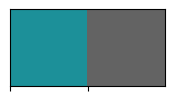

In [4]:
from enum import Enum
class my_colors(Enum):
    CONTROL = "#636363"
    PD = "#1c9099"
    
color_list = [my_colors.PD.value, my_colors.CONTROL.value,]
palette = sns.color_palette(palette=color_list) #sns.husl_palette()

sns.palplot(palette)

### manifest

In [41]:
manifest_cols = ["participant_id", "visit", "session"]

manifest_df = pd.read_csv(manifest_csv)
manifest_df = manifest_df[manifest_cols]

manifest_participants = manifest_df["participant_id"].unique()
n_manifest_participants = len(manifest_participants)
print(f"manifest participants: {n_manifest_participants}")


# merge with doughnut_csv
doughnut_df = pd.read_csv(doughnut_csv, usecols=["participant_id","bids_id"])

manifest_df = pd.merge(manifest_df, doughnut_df, on="participant_id", how="inner")
manifest_df.head()

manifest participants: 328


,participant_id,visit,session,bids_id
0,YLOPD_01,Intake,ses-01,sub-YLOPD01
1,YLOPD_02,Intake,ses-01,sub-YLOPD02
2,YLOPD_03,Intake,ses-01,sub-YLOPD03
3,YLOPD_03,Intake,ses-01,sub-YLOPD03
4,YLOPD_03,Follow up 1,ses-02,sub-YLOPD03


### Demographic data

In [44]:
demographics_df = pd.read_csv(demographics_csv)
demographics_df = demographics_df.rename(columns={"redcap_event_name": "visit"})
demographics_df = demographics_df[demographics_df["visit"]=="Intake"].copy()

participants = demographics_df["participant_id"].unique()
n_participants = len(participants)
print(f"n_participants: {n_participants}")
group_counts = demographics_df.groupby(["diag"]).count()
print(f"group counts: {group_counts}")
demographics_df.head()

n_participants: 328
group counts:       participant_id  visit  age_assessment  gender
diag                                               
HC                55     55              50      51
PD               273    273             267     267


,participant_id,visit,age_assessment,gender,diag
0,YLOPD_01,Intake,51.0,Male,PD
1,YLOPD_02,Intake,66.0,Male,PD
2,YLOPD_03,Intake,65.0,Male,PD
4,YLOPD_04,Intake,59.0,Male,PD
6,YLOPD_05,Intake,43.0,Female,PD


### Merge demographics and manifest

In [45]:
demographics_df = pd.merge(demographics_df, manifest_df, on=["participant_id", "visit"])


demographics_df.head()

,participant_id,visit,age_assessment,gender,diag,session,bids_id
0,YLOPD_01,Intake,51.0,Male,PD,ses-01,sub-YLOPD01
1,YLOPD_02,Intake,66.0,Male,PD,ses-01,sub-YLOPD02
2,YLOPD_03,Intake,65.0,Male,PD,ses-01,sub-YLOPD03
3,YLOPD_03,Intake,65.0,Male,PD,ses-01,sub-YLOPD03
4,YLOPD_04,Intake,59.0,Male,PD,ses-01,sub-YLOPD04


### Read DKT data

In [46]:
DKT_ROIs = ['caudalanteriorcingulate', 'caudalmiddlefrontal','cuneus', 'entorhinal', 'fusiform', 'inferiorparietal',
       'inferiortemporal', 'isthmuscingulate', 'lateraloccipital','lateralorbitofrontal', 'lingual', 'medialorbitofrontal',
       'middletemporal', 'parahippocampal', 'paracentral', 'parsopercularis', 'parsorbitalis', 'parstriangularis',
       'pericalcarine', 'postcentral', 'posteriorcingulate', 'precentral', 'precuneus', 'rostralanteriorcingulate',
       'rostralmiddlefrontal', 'superiorfrontal', 'superiorparietal', 'superiortemporal', 'supramarginal', 'transversetemporal',
       'insula']

lh_DKT_ROIs_dict = dict(zip(list("lh." + pd.Series(DKT_ROIs)), DKT_ROIs))
rh_DKT_ROIs_dict = dict(zip(list("rh." + pd.Series(DKT_ROIs)), DKT_ROIs))

In [47]:
CT_DKT_df = pd.read_csv(DKT_csv)
CT_DKT_df = CT_DKT_df.rename(columns={"participant_id":"bids_id"})

bids_ids = CT_DKT_df["bids_id"].unique()
print(f"n_bids: {len(bids_ids)}")

# Merge with demographics
CT_DKT_df = pd.merge(CT_DKT_df,demographics_df,on="bids_id",how="left")
CT_DKT_df.head()

n_bids: 237


,bids_id,lh.caudalanteriorcingulate,lh.caudalmiddlefrontal,lh.cuneus,lh.entorhinal,lh.fusiform,lh.inferiorparietal,lh.inferiortemporal,lh.isthmuscingulate,lh.lateraloccipital,...,rh.supramarginal,rh.transversetemporal,rh.insula,rh.temporalpole,participant_id,visit,age_assessment,gender,diag,session
0,sub-YLOPD03,2.379,2.373,1.788,3.446,2.741,2.436,3.003,2.194,2.147,...,2.466,1.879,2.898,NaN,YLOPD_03,Intake,65.0,Male,PD,ses-01
1,sub-YLOPD03,2.379,2.373,1.788,3.446,2.741,2.436,3.003,2.194,2.147,...,2.466,1.879,2.898,NaN,YLOPD_03,Intake,65.0,Male,PD,ses-01
2,sub-YLOPD04,2.646,2.641,1.677,3.324,2.506,2.270,2.898,2.497,2.033,...,2.571,2.006,2.893,NaN,YLOPD_04,Intake,59.0,Male,PD,ses-01
3,sub-YLOPD04,2.646,2.641,1.677,3.324,2.506,2.270,2.898,2.497,2.033,...,2.571,2.006,2.893,NaN,YLOPD_04,Intake,59.0,Male,PD,ses-01
4,sub-YLOPD05,2.575,2.483,1.652,3.280,2.543,2.374,2.812,2.296,2.028,...,2.433,2.245,3.270,NaN,YLOPD_05,Intake,43.0,Female,PD,ses-01


### Split DKT data into left and right hemisphere

In [48]:
save_results = False

demo_cols = ["participant_id","bids_id", "age_assessment","gender","diag"]

lh_CT_DKT_df = CT_DKT_df[demo_cols + list(lh_DKT_ROIs_dict.keys())].copy()
rh_CT_DKT_df = CT_DKT_df[demo_cols + list(rh_DKT_ROIs_dict.keys())].copy()

lh_CT_DKT_df = lh_CT_DKT_df.rename(columns=lh_DKT_ROIs_dict)
lh_CT_DKT_df["hemi"] = "lh"
rh_CT_DKT_df = rh_CT_DKT_df.rename(columns=rh_DKT_ROIs_dict)
rh_CT_DKT_df["hemi"] = "rh"

CT_DKT_df = pd.concat([lh_CT_DKT_df,rh_CT_DKT_df], axis=0)

if save_results:
    CT_DKT_df.to_csv(f"{results_dir}/CT_DKT_df.csv")

CT_DKT_df.head()

,participant_id,bids_id,age_assessment,gender,diag,caudalanteriorcingulate,caudalmiddlefrontal,cuneus,entorhinal,fusiform,...,precuneus,rostralanteriorcingulate,rostralmiddlefrontal,superiorfrontal,superiorparietal,superiortemporal,supramarginal,transversetemporal,insula,hemi
0,YLOPD_03,sub-YLOPD03,65.0,Male,PD,2.379,2.373,1.788,3.446,2.741,...,2.588,2.697,2.359,2.713,2.183,2.820,2.500,2.213,3.112,lh
1,YLOPD_03,sub-YLOPD03,65.0,Male,PD,2.379,2.373,1.788,3.446,2.741,...,2.588,2.697,2.359,2.713,2.183,2.820,2.500,2.213,3.112,lh
2,YLOPD_04,sub-YLOPD04,59.0,Male,PD,2.646,2.641,1.677,3.324,2.506,...,2.146,2.986,2.420,2.836,2.039,2.737,2.414,1.921,3.182,lh
3,YLOPD_04,sub-YLOPD04,59.0,Male,PD,2.646,2.641,1.677,3.324,2.506,...,2.146,2.986,2.420,2.836,2.039,2.737,2.414,1.921,3.182,lh
4,YLOPD_05,sub-YLOPD05,43.0,Female,PD,2.575,2.483,1.652,3.280,2.543,...,2.244,2.443,2.201,2.563,2.074,2.861,2.477,2.342,3.063,lh


In [72]:
CT_DKT_df_melt[["diag","hemi","CT"]].groupby(["diag","hemi"]).mean()
# CT_DKT_df_melt.head()

CT
diag hemi          
HC   lh    2.504159
     rh    2.500560
PD   lh    2.423354
     rh    2.424032

### Plot DKT

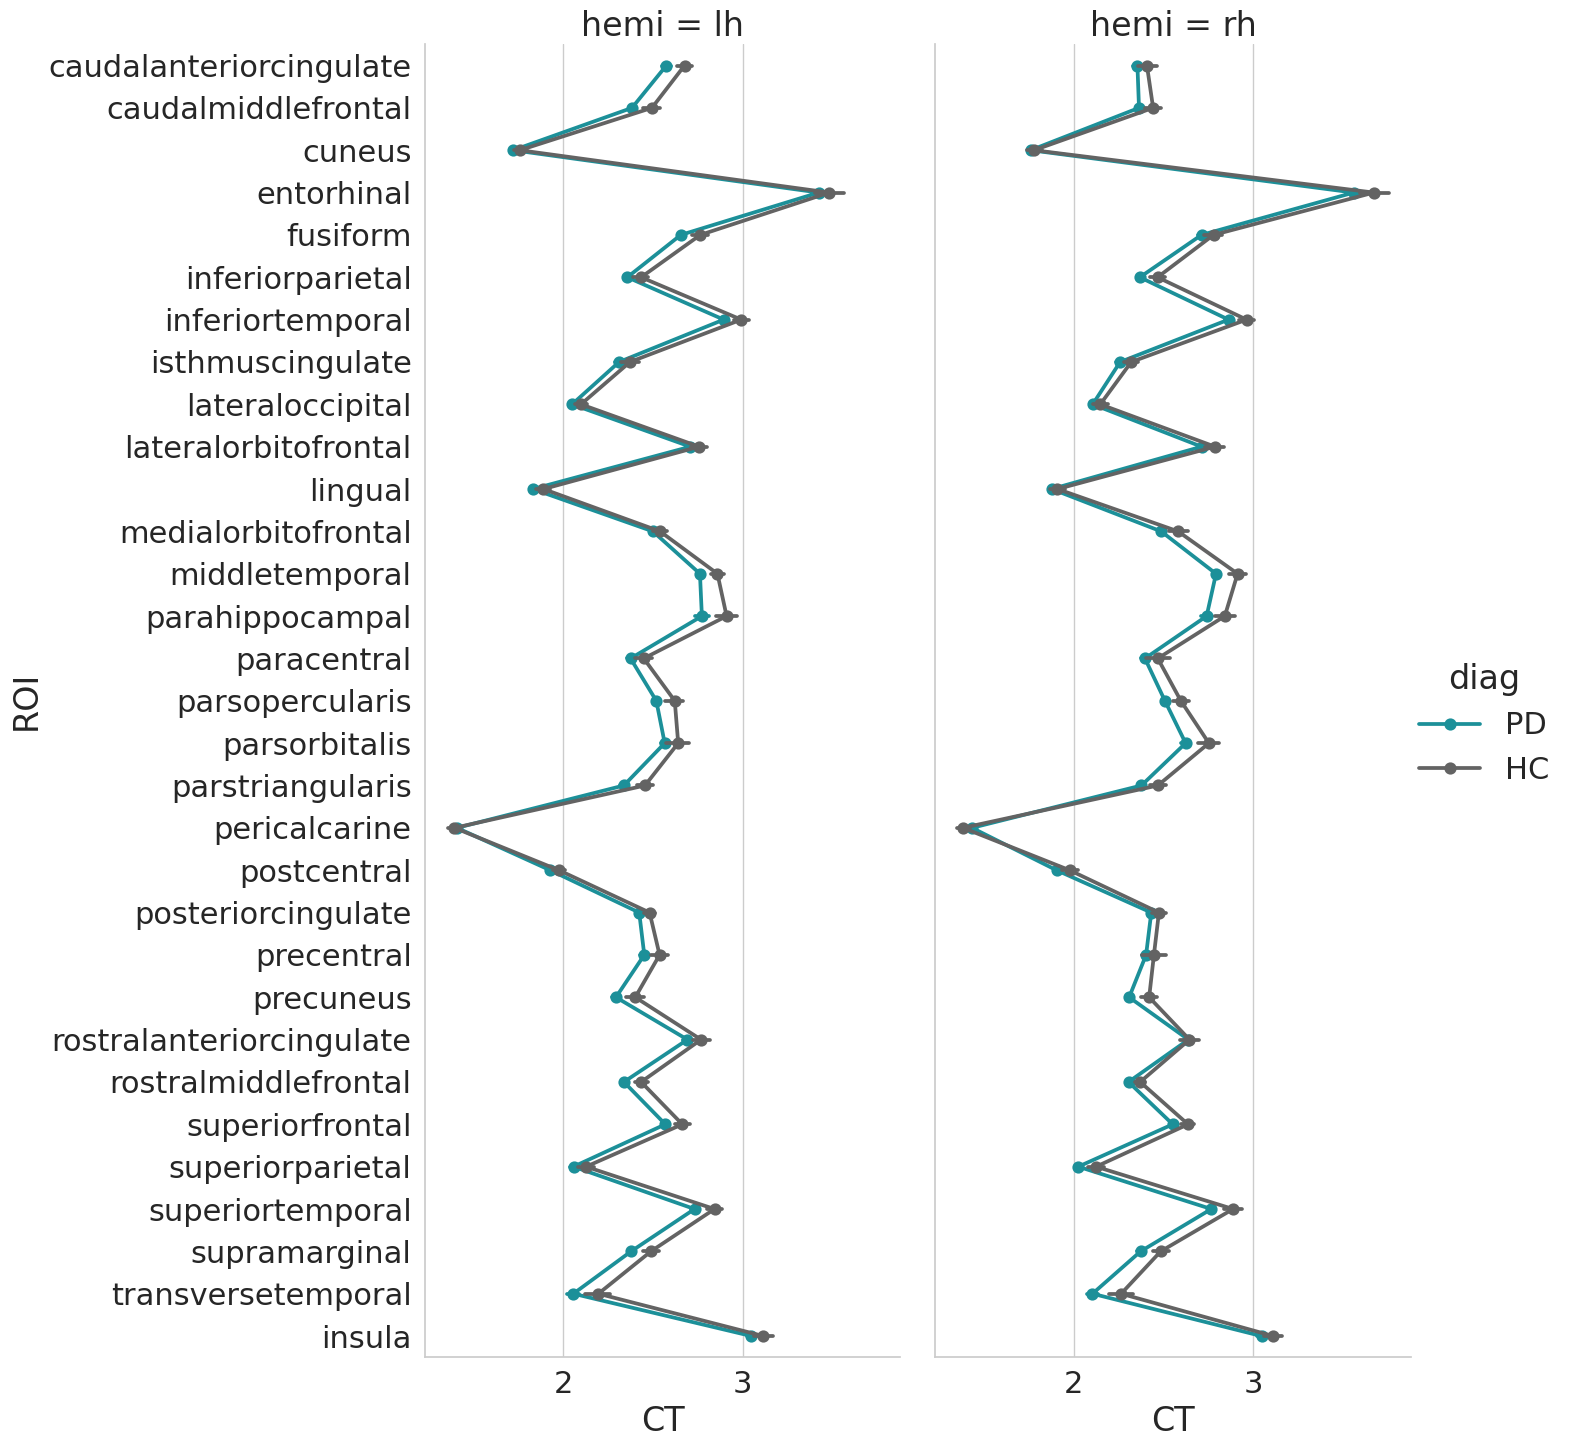

In [65]:
save_fig = False

CT_DKT_df_melt = CT_DKT_df.melt(
    id_vars=demo_cols + ["hemi"],
    var_name="ROI", 
    value_name="CT")

plot_df = CT_DKT_df_melt.copy()
plot_df["ROI"] = plot_df["ROI"].astype(str)

sns.set(font_scale=2)
plot_kind = "point" # "violin", "boxen", "point", "bar", or “strip”
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="ROI",x="CT", hue="diag", col="hemi",kind=plot_kind,palette=palette, data=plot_df, aspect=0.5, height=15)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

if save_fig:
    g.savefig(f"{figs_dir}/DKT.png")

### Volumetric measures

In [51]:
vol_ASEG_df = pd.read_csv(ASEG_csv)
vol_ASEG_df = vol_ASEG_df.rename(columns={"participant_id":"bids_id"})

bids_ids = list(vol_ASEG_df["bids_id"])
print(f"n_bids: {len(bids_ids)}")

# Merge with demographics info
vol_ASEG_df = pd.merge(vol_ASEG_df,demographics_df,on="bids_id",how="left")

vol_ASEG_df.head()

n_bids: 237


,bids_id,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,...,lhSurfaceHoles,rhSurfaceHoles,SurfaceHoles,EstimatedTotalIntraCranialVol,participant_id,visit,age_assessment,gender,diag,session
0,sub-YLOPD03,19963.8,669.4,14188.6,46697.8,7166.7,4008.2,4630.1,2025.0,1698.3,...,12,5,17,1.614941e+06,YLOPD_03,Intake,65.0,Male,PD,ses-01
1,sub-YLOPD03,19963.8,669.4,14188.6,46697.8,7166.7,4008.2,4630.1,2025.0,1698.3,...,12,5,17,1.614941e+06,YLOPD_03,Intake,65.0,Male,PD,ses-01
2,sub-YLOPD04,10746.6,677.4,10071.6,38089.1,4693.3,2555.0,3754.2,1766.4,1277.7,...,2,3,5,1.230620e+06,YLOPD_04,Intake,59.0,Male,PD,ses-01
3,sub-YLOPD04,10746.6,677.4,10071.6,38089.1,4693.3,2555.0,3754.2,1766.4,1277.7,...,2,3,5,1.230620e+06,YLOPD_04,Intake,59.0,Male,PD,ses-01
4,sub-YLOPD05,9871.0,295.2,8874.7,32588.9,6102.1,2771.3,3283.3,1402.6,1339.6,...,1,4,5,1.214994e+06,YLOPD_05,Intake,43.0,Female,PD,ses-01


In [52]:
aseg_cols = list(vol_ASEG_df.columns)

lh_aseg_ROIs_cols = [col for col in aseg_cols if "Left" in col]
rh_aseg_ROIs_cols = [col for col in aseg_cols if "Right" in col]

aseg_hemi_ROIs = [col.split("-",1)[1] for col in lh_aseg_ROIs_cols]

aseg_global_ROIs = list(set(aseg_cols) - set(lh_aseg_ROIs_cols) - set(rh_aseg_ROIs_cols) - set(demo_cols))

lh_aseg_ROIs_dict = dict(zip(lh_aseg_ROIs_cols, aseg_hemi_ROIs))
rh_aseg_ROIs_dict = dict(zip(rh_aseg_ROIs_cols, aseg_hemi_ROIs))

### Split ASEG data into left and right hemisphere

In [53]:
save_results = False

lh_vol_ASEG_df = vol_ASEG_df[demo_cols + list(lh_aseg_ROIs_dict.keys())].copy()
lh_vol_ASEG_df["hemi"] = "lh"
rh_vol_ASEG_df = vol_ASEG_df[demo_cols + list(rh_aseg_ROIs_dict.keys())].copy()
rh_vol_ASEG_df["hemi"] = "rh"
global_vol_ASEG_df = vol_ASEG_df[aseg_global_ROIs + demo_cols].copy()
global_vol_ASEG_df["hemi"] = "global"

lh_vol_ASEG_df = lh_vol_ASEG_df.rename(columns=lh_aseg_ROIs_dict)
rh_vol_ASEG_df = rh_vol_ASEG_df.rename(columns=rh_aseg_ROIs_dict)

bilateral_vol_ASEG_df = pd.concat([lh_vol_ASEG_df,rh_vol_ASEG_df], axis=0)

if save_results:
    bilateral_vol_ASEG_df.to_csv(f"{results_dir}/bilateral_vol_ASEG_df.csv")
    global_vol_ASEG_df.to_csv(f"{results_dir}/global_vol_ASEG_df.csv")

bilateral_vol_ASEG_df.head()

,participant_id,bids_id,age_assessment,gender,diag,Lateral-Ventricle,Inf-Lat-Vent,Cerebellum-White-Matter,Cerebellum-Cortex,Thalamus,...,Pallidum,Hippocampus,Amygdala,Accumbens-area,VentralDC,vessel,choroid-plexus,WM-hypointensities,non-WM-hypointensities,hemi
0,YLOPD_03,sub-YLOPD03,65.0,Male,PD,19963.8,669.4,14188.6,46697.8,7166.7,...,2025.0,4074.7,1870.5,396.0,4049.8,31.6,1242.1,0.0,0.0,lh
1,YLOPD_03,sub-YLOPD03,65.0,Male,PD,19963.8,669.4,14188.6,46697.8,7166.7,...,2025.0,4074.7,1870.5,396.0,4049.8,31.6,1242.1,0.0,0.0,lh
2,YLOPD_04,sub-YLOPD04,59.0,Male,PD,10746.6,677.4,10071.6,38089.1,4693.3,...,1766.4,3414.9,1334.0,206.8,3158.8,0.0,931.8,0.0,0.0,lh
3,YLOPD_04,sub-YLOPD04,59.0,Male,PD,10746.6,677.4,10071.6,38089.1,4693.3,...,1766.4,3414.9,1334.0,206.8,3158.8,0.0,931.8,0.0,0.0,lh
4,YLOPD_05,sub-YLOPD05,43.0,Female,PD,9871.0,295.2,8874.7,32588.9,6102.1,...,1402.6,4143.8,1657.3,460.2,3734.8,18.7,608.8,0.0,0.0,lh


### Plot ASEG
- hemi 
- global

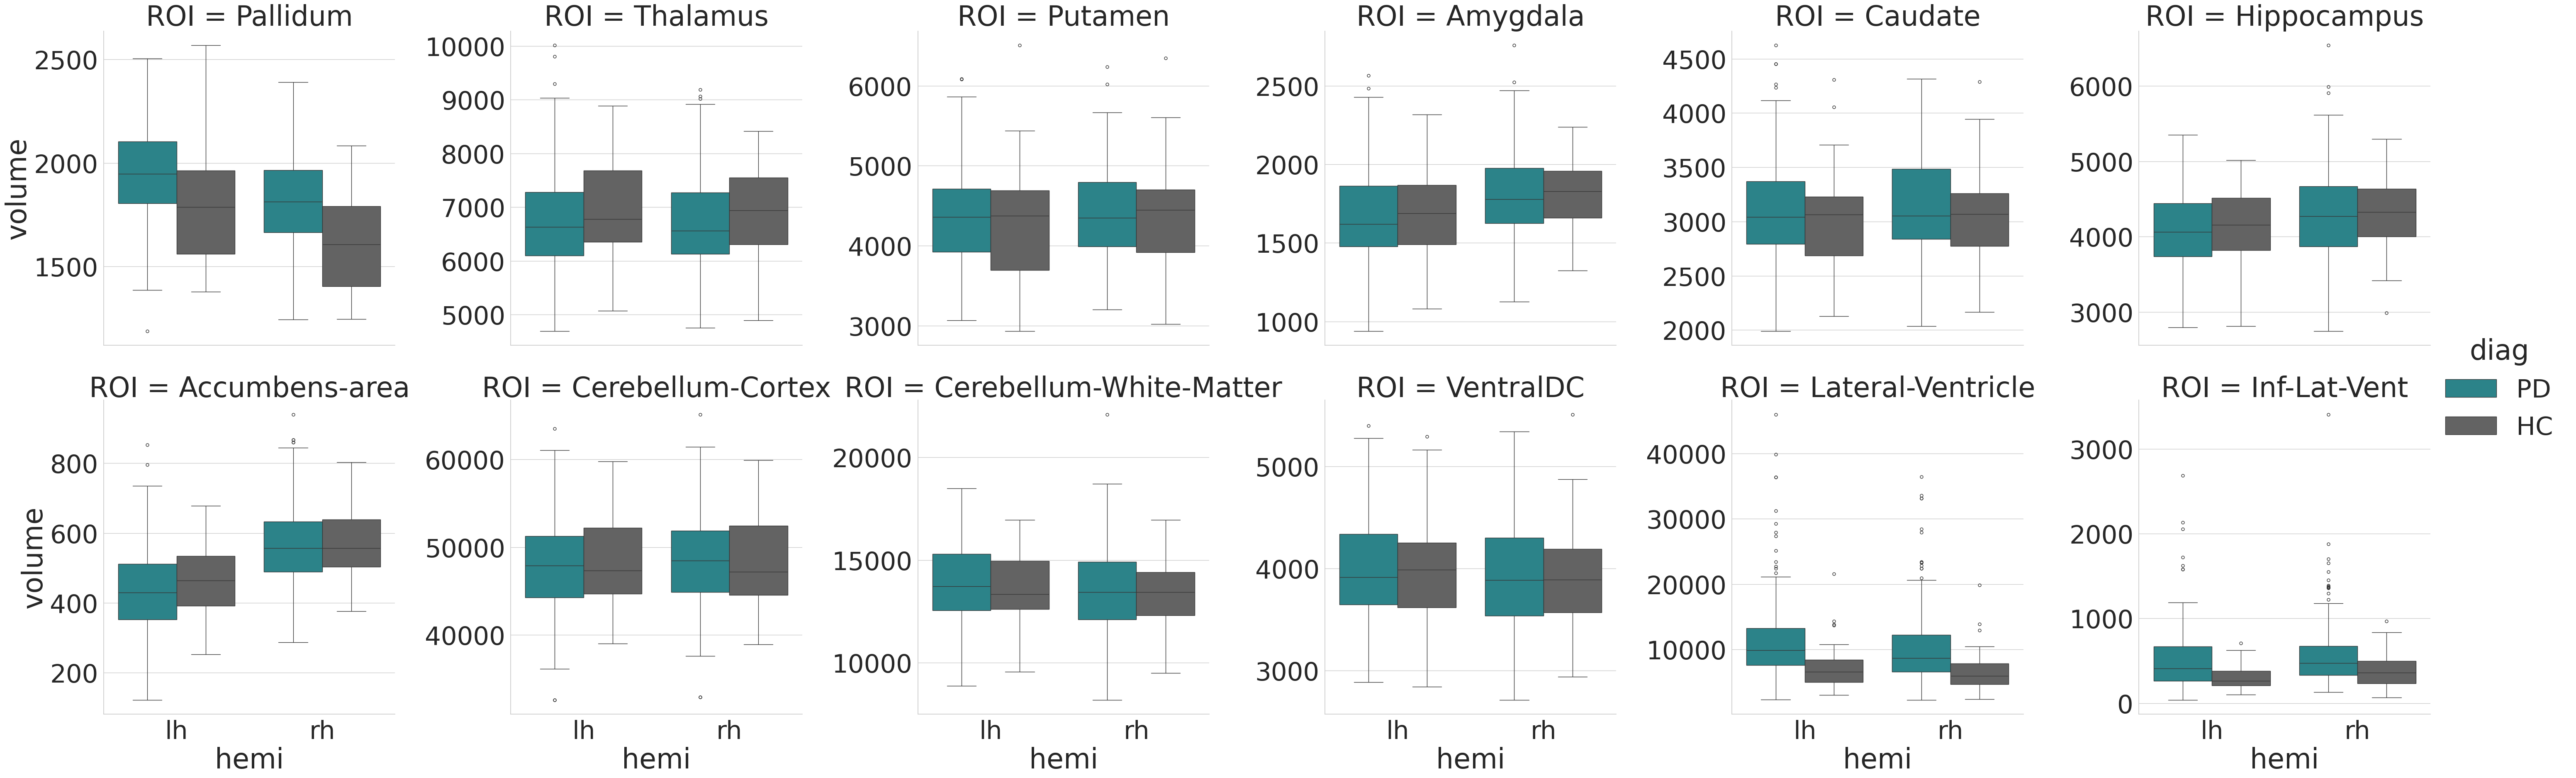

In [60]:
save_fig = False

vol_ASEG_df_melt = bilateral_vol_ASEG_df.melt(
    id_vars=demo_cols + ["hemi"],
    var_name="ROI", 
    value_name="volume",
)

plot_df = vol_ASEG_df_melt.copy()
plot_df["ROI"] = plot_df["ROI"].astype(str)
hemi_roi_list = ['Pallidum', 'Thalamus', 'Putamen',  'Amygdala', 'Caudate', 'Hippocampus', 'Accumbens-area', 
                'Cerebellum-Cortex','Cerebellum-White-Matter','VentralDC', 'Lateral-Ventricle','Inf-Lat-Vent']

sns.set(font_scale=4)
plot_kind = "box" # "violin", "boxen", "point", "bar", or “strip”
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="volume",x="hemi", hue="diag", col="ROI", kind=plot_kind, col_wrap=6, col_order=hemi_roi_list,
    palette=palette, data=plot_df, aspect=1, height=10, sharey=False)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

if save_fig:
    g.savefig(f"{figs_dir}/ASEG_hemi.png")

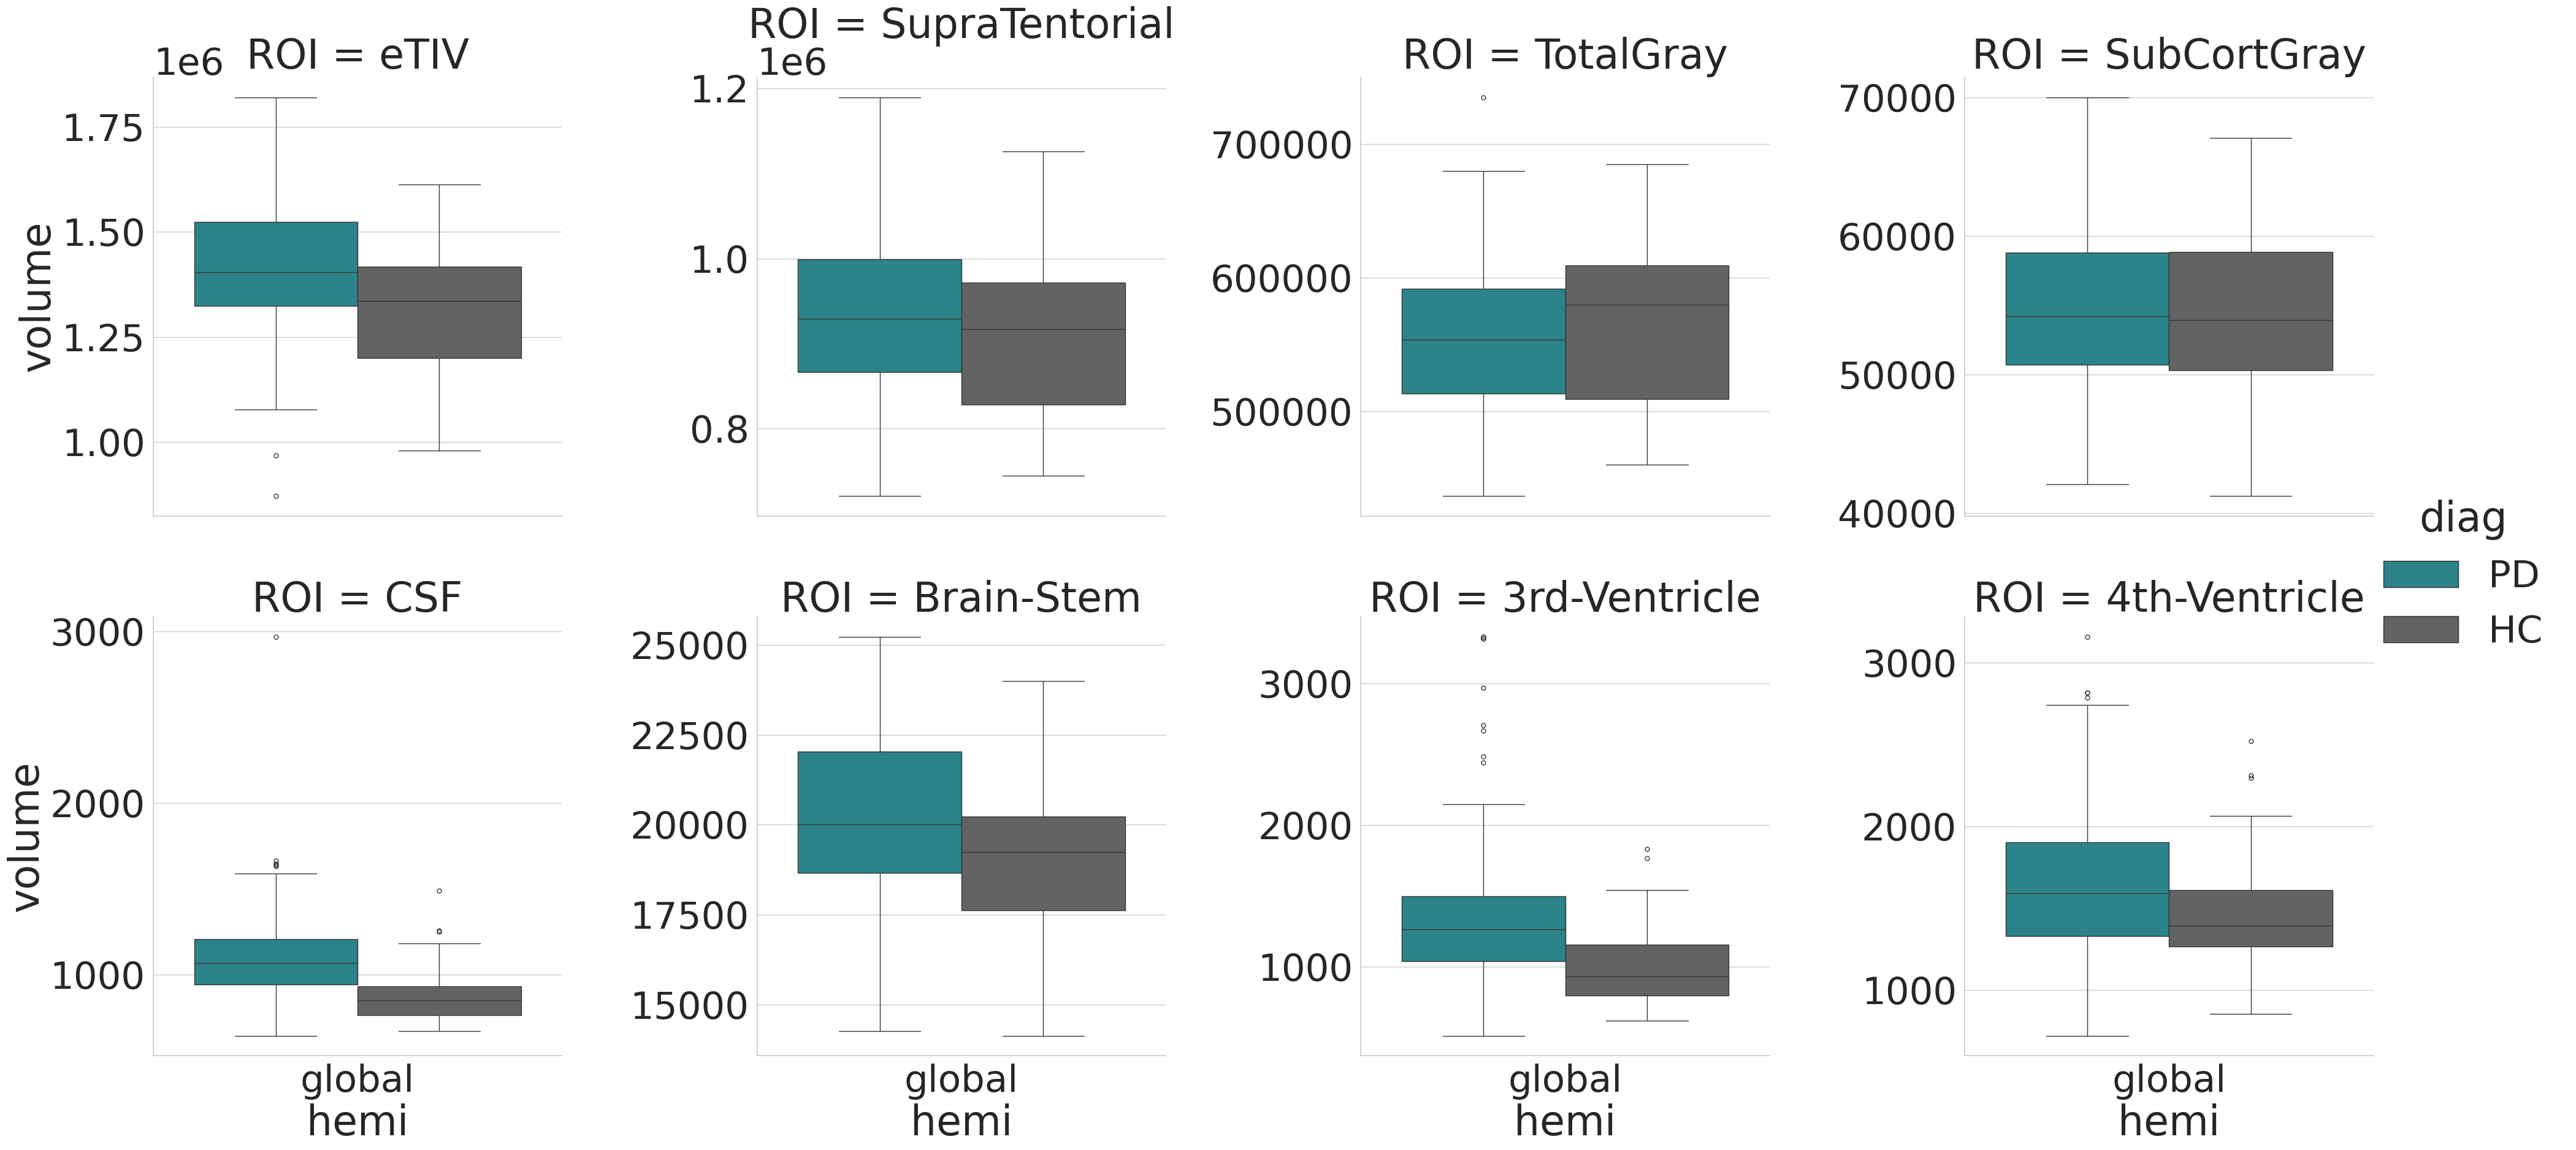

In [62]:
save_fig = False

global_vol_ASEG_df = global_vol_ASEG_df.rename(columns={"EstimatedTotalIntraCranialVol":"eTIV"})
global_vol_ASEG_df_melt = global_vol_ASEG_df.melt(
    id_vars=demo_cols + ["hemi"],
    var_name="ROI", 
    value_name="volume",
)

plot_df = global_vol_ASEG_df_melt.copy()

global_roi_list = ["eTIV", "SupraTentorial", "TotalGray", "SubCortGray", 
                    "CSF","Brain-Stem","3rd-Ventricle","4th-Ventricle"]
plot_df = plot_df[plot_df["ROI"].isin(global_roi_list)]

sns.set(font_scale=4)
plot_kind = "box" # "violin", "boxen", "point", "bar", or “strip”
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="volume",x="hemi", hue="diag", col="ROI", kind=plot_kind, col_wrap=4, col_order=global_roi_list,
    palette=palette, data=plot_df, aspect=1, height=10, sharey=False)

if save_fig:
    g.savefig(f"{figs_dir}/ASEG_global.png")